# Importing libraries

In [1]:
# Import libraries and check if there is any uninstalled
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
from neo.io import WinWcpIO
from scipy import signal
import os
import re
import joblib


# Helper functions

In [2]:
def choose_folder():
    global LA
    root = Tk() # pointing root to Tk() to use it as Tk() in program.
    root.withdraw() # Hides small tkinter window.
    root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
    folder_path = filedialog.askdirectory() # Returns opened path as str
    print(f'Folder chosen: {folder_path}')
    LA = folder_path
    return folder_path

def get_cell_number(folder):
    match = re.search(r'[Cc]ell\s(\d+)', folder)
    if match:
        return int(match.group(1))
    return None


In [19]:
def load_data(protocol, group, folder):
    import os
    import re
    import xarray as xr
    from neo.io import WinWcpIO

    data = {}
    files = os.listdir(folder)

    # Filter and sort files by creation time that match the given protocol
    filtered_files = [(file, os.path.getctime(os.path.join(folder, file))) for file in files if re.findall(protocol, file)]
    filtered_files.sort(key=lambda x: x[1])  # Sort by creation time stored in the tuple
    if not filtered_files:
        raise FileNotFoundError(f"No files found for protocol {protocol}")
    cell_number = get_cell_number(folder)

    for sweep_idx, (file, creation_time) in enumerate(filtered_files, start=1):
        path = os.path.join(folder, file)
        fileIO = WinWcpIO(filename=path)
        block = fileIO.read_block()

        for step_idx, segment in enumerate(block.segments, start=1):
            time_data = segment.analogsignals[0].times.magnitude
            voltage_data = segment.analogsignals[0].magnitude[:,0]
            key = (cell_number, group, protocol, sweep_idx, step_idx)
            
            data[key] = xr.DataArray(voltage_data, coords={'time': time_data, 'creation_time': creation_time}, dims=['time'])

    return data

def get_group_selection(groups):
    import sys
    while True:
        for idx, group in enumerate(groups):
            print(idx, ':', group)
        sys.stdout.flush()
        try:
            selected_idx = int(input("Enter the index of the group the chosen folder belongs to: "))
            if 0 <= selected_idx < len(groups):
                return groups[selected_idx]  
            else:
                print("Invalid index. Please enter a number between 0 and", len(groups) - 1)
        except ValueError:
            print("Invalid input. Please enter a numeric index.")
        except KeyboardInterrupt:
            print("\nInput cancelled. Exiting selection.")
            return None  

def ton_filter(y,order,fs):
    cutoff = fs
    b, a = signal.butter(order, fs, 'lowpass')
    filtered_r = signal.filtfilt(b, a, y,axis=0)
    return filtered_r

def adjust_lightness(color, amount=1.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
        
def save_joblib(data, file_path):
    from joblib import dump
    dump(data, file_path)
    
def load_joblib(file_path):
    from joblib import load
    return load(file_path)

def delete_cell_data(data, cell):
    keys_to_delete = [key for key in data.keys() if key[0] == cell]
    
    for key in keys_to_delete:
        del data[key]
    
    print(f"Deleted data for cell: {cell}")
    
def get_fs(fs_steps, step):
    return fs_steps.get(step, 0.4)


# Ingestion

In [4]:
folder = choose_folder()
path_to_data = os.path.join(folder, 'all_data.joblib')

if os.path.exists(path_to_data):
    all_data = load_joblib(path_to_data)  # Load data already consolidated
    print('Loading dataset found')
else:
    all_data = {}  # Initialize as an empty dictionary if no data ingested before
    print('File not found, loading data into new dict')

Folder chosen: C:/Users/aelto/Documents/GitHub/behavis/Example data
File not found, loading data into new dict


In [8]:
groups = ['base', 'sevo','sevo+tytx', 'wash']
protocols = ['short','long','ramp','Rheobase','VC']

folder = choose_folder()
selected_group = get_group_selection(groups)
if selected_group is not None:
    print(f"You selected: {selected_group}")
else:
    print("No group selected.")

for protocol in protocols:
    try:
        patch_data = load_data(protocol, selected_group, folder)
        all_data.update(patch_data)  
        print(f'Data for protocol {protocol} added')
        
    except Exception as err:
        print(f'Could not load protocol {protocol}, error: {err}')
    

Folder chosen: C:/Users/aelto/Documents/GitHub/behavis/Example data/cell 63/wash
0 : base
1 : sevo
2 : sevo+tytx
3 : wash
You selected: wash
Data for protocol short added
Data for protocol long added
Data for protocol ramp added
Data for protocol Rheobase added
Data for protocol VC added


In [9]:
save_joblib(all_data, path_to_data)


# Visualing data

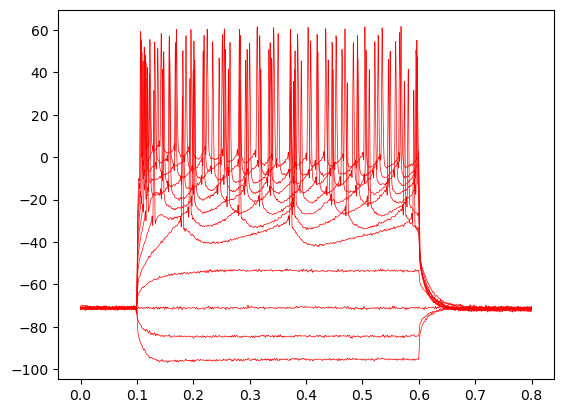

In [ ]:
# Plotting all steps for one sweep of a given cell and group
cell_number = 63
group = 'base'
protocol = 'short'
sweep = 2

fs = 0.3
step_list = [i for i in range(1, 13) ] 

for step in step_list:
    data_key = (cell_number, group, protocol, sweep, step)
    if data_key in all_data:
        voltage_data = all_data[data_key]
        time_points = voltage_data.coords['time']
        plt.plot(time_points, ton_filter(voltage_data,4,fs),color='#FF0000',lw=0.5)
    else:
        print(f"Data not found for: Cell {cell_number}, Group {group}, Protocol {protocol}, Sweep {sweep}, Step {step}")

Processing group: base
Processing group: sevo
Processing group: sevo+tytx
Processing group: wash


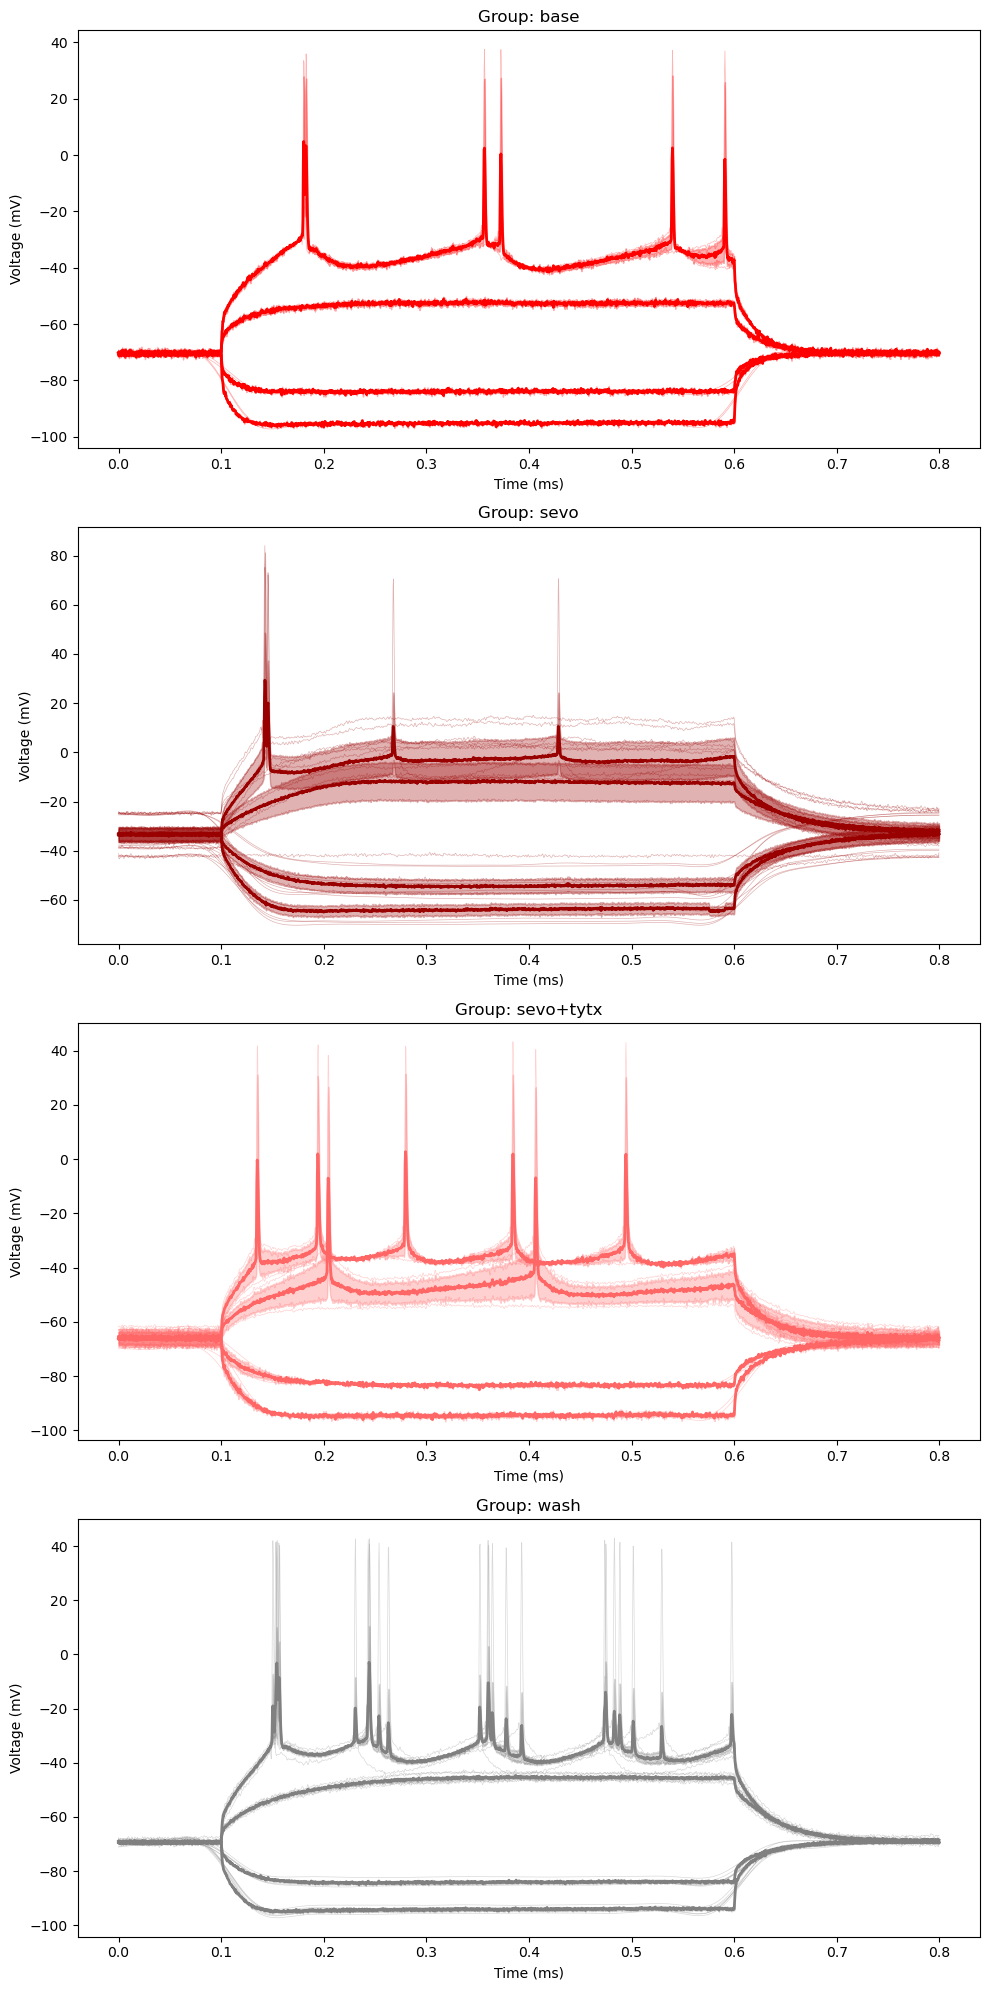

In [23]:
# Comparing variation between replicates (sweeps) across groups

groups = ['base', 'sevo','sevo+tytx', 'wash']

colors = {
    'base': '#FF0000',  # Bright red
    'sevo': adjust_lightness('#FF0000', 0.6),
    'sevo+tytx': adjust_lightness('#FF0000', 1.4),
    'wash': 'gray',
}

# Define fs used in butterworth filter for individual steps
fs_steps = {
    1: 0.01,
    2: 0.01,
    # 0.4 default for any other step
}
# Define a specific key to access data
cell_number = 63
protocol = 'short'
sweep = 2
step_list = [i for i in range(1, 6) if i not in [3] ] 

# Create subplots
fig, axes = plt.subplots(nrows=len(groups), figsize=(10, 20))
if len(groups) == 1:
    axes = [axes]

for ax, group in zip(axes, groups):
    print(f"Processing group: {group}")

    # Iterate through each step
    for step in step_list:
        step_data = []
        sweep = 1  # Start checking from the first sweep

        # Continue checking for data as long as it's found for the current sweep
        while True:
            data_key = (cell_number, group, protocol, sweep, step)
            if data_key in all_data:
                voltage_data = all_data[data_key]
                time_points = voltage_data.coords['time']
                filtered_data = ton_filter(voltage_data, 4, get_fs(fs_steps, step))
                step_data.append(voltage_data)

                # Plot individual traces faintly for the current step
                ax.plot(time_points, filtered_data, color=colors.get(group, 'black'), alpha=0.3, lw=0.5)

                sweep += 1  # Move to the next sweep
            else:
                break  # Stop if no data is found for the current sweep

        if step_data:
            # Calculate mean and SEM for the current step across found sweeps
            step_data = np.array(step_data)
            mean_data = np.mean(step_data, axis=0)
            sem_data = np.std(step_data, axis=0) / np.sqrt(step_data.shape[0])

            # Plot mean and SEM for the current step
            ax.plot(time_points, mean_data, color=colors.get(group, 'black'), lw=2)
            ax.fill_between(time_points, mean_data - sem_data, mean_data + sem_data, color=colors.get(group, 'black'), alpha=0.3)

    ax.set_title(f"Group: {group}")
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (mV)')

plt.tight_layout()
plt.show()

# Summirizing data collected using pandas

In [24]:
path = r'dfCuredData.csv'
df = pd.read_csv(path)
df_included = df[df['Exclusion criteria'] == 'Included']

cat_vars = ['neuron.type','Sevoflurane']
num_vars = ['Ri (MΩ)','Vm (mV)','Hyperpolarization (mV)','AP Half-width (ms)','Threshold','Rheobase','Δsag (mV)','ΔAHP (mV)','ΔADP (mV)','FF at 50 pA (Hz)', 'FF at 100 pA (Hz)', 'FF at 150 pA (Hz)', 'FF at 200 pA (Hz)','FF at 250 pA (Hz)', 'FF at 300 pA (Hz)','FF at 350 pA (Hz)','FF at 400 pA (Hz)','FF at 450 pA (Hz)']
ff_list = ['FF at -50 pA (Hz)','FF at -100 pA (Hz)','FF at 50 pA (Hz)','FF at 100 pA (Hz)', 'FF at 150 pA (Hz)',
        'FF at 200 pA (Hz)','FF at 250 pA (Hz)', 'FF at 300 pA (Hz)',
       'FF at 350 pA (Hz)', 'FF at 400 pA (Hz)', 'FF at 450 pA (Hz)']
membrane_properties = [var for var in num_vars if var not in ff_list]

df_cleaned = df_included.dropna(subset=num_vars)
counts = df_cleaned.groupby(['Sevoflurane', 'neuron.type']).size().reset_index(name='counts')
print(counts)


    Sevoflurane neuron.type  counts
0      Baseline           A      21
1      Baseline           B      16
2   Sevo + Tytx           A       8
3   Sevo + Tytx           B       5
4     Sevo 0.5%           A      10
5     Sevo 0.5%           B      12
6          Tytx           A       3
7          Tytx           B       2
8  Washout 0.5%           A       5
9  Washout 0.5%           B       5
